In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV,train_test_split
from sklearn.metrics import *
from sklearn.impute import SimpleImputer
import optuna

In [2]:
#from scipy.stats import skew
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import mean_squared_error
#from math import sqrt
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
#from lightgbm import LGBMClassifier
# import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC, NuSVC

In [3]:
MISSING = -9999

In [4]:
SEED = 123321

In [5]:
df = pd.read_csv("../data/processed/data_encoded_stacking.csv")

In [6]:
df.shape

(39325, 353)

In [7]:
df_train = df[df["test"] == 0].drop(columns=["test"]).set_index("id")
df_test = df[df["test"] == 1].drop(columns=["test"]).set_index("id")

In [8]:
X = df_train.drop(columns=["satisfied"])
y = df_train["satisfied"]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=SEED)

In [10]:
X_train["satisfied"] = y_train

/Users/tingwei758/opt/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
X_test["satisfied"] = y_test

/Users/tingwei758/opt/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
X_final = df_test.drop(columns=["satisfied"])

In [13]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_final = X_final.reset_index(drop=True)

In [14]:
X_train.shape

(21056, 351)

In [15]:
X_test.shape

(9024, 351)

In [16]:
X_final.shape

(9245, 350)

In [17]:
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        imp = SimpleImputer(missing_values=MISSING, strategy='constant', fill_value=0)
        x_train = imp.fit_transform(x_train)
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        imp = SimpleImputer(missing_values=MISSING, strategy='constant', fill_value=0)
        x = imp.fit_transform(x)
        return self.clf.predict_proba(x)[:,1]

In [18]:
class CatboostWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

In [19]:
class XgbWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

In [20]:
# class XgbWrapper(object):
#     def __init__(self, seed=0, params=None):
#         self.param = params
#         self.param['seed'] = seed
#         self.nrounds = params.pop('nrounds', 250)

#     def train(self, x_train, y_train):
#         dtrain = xgb.DMatrix(x_train, label=y_train)
#         res = xgb.cv(self.param, dtrain, num_boost_round=250, nfold=3, stratified=True,
#              early_stopping_rounds=25, verbose_eval=False, show_stdv=True) #cv寻找较优的迭代次数
#         self.nrounds = res.shape[0]
#         #print (res)
#         self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

#     def predict(self, x):
#         return self.gbdt.predict(xgb.DMatrix(x))

In [21]:
class LightGBMWrapper(object):
    def __init__(self, seed=0, params=None):
        params['seed'] = seed
        self.params = params

    def train(self, x_train, y_train):
        dtrain = lgb.Dataset(x_train,label=y_train)
        bst = lgb.cv(self.params, dtrain, num_boost_round=1000, nfold=3, early_stopping_rounds=30) #cv寻找较优的迭代次数
        self.lgbc = lgb.train(self.params,dtrain,num_boost_round=len(bst['auc-mean']))

    def predict(self, x):
        return self.lgbc.predict(np.array(x))

In [29]:
class ModelStacking():
    def __init__(self, train_data, test_data, online_data, predictors, models=['et','rf','xgb','cb','lgb'], dep='y',nfolds=5, seed=0, trial=None):
        '''
        train_data: DataFrame, 训练集;
        test_data: DataFrame, 测试集;
        online_data: DataFrame, 待预测样本;
        predictors：list or array, 待训练变量名;
        models: list, 模型名称;
        dep: str, y值;
        nfolds: int, stacking的折数;
        seed: int, 随机种子;
        '''
        self.train_data = train_data #训练集
        self.test_data = test_data #测试集（带label)
        self.online_data = online_data #需要预测的数据集（label未知）
        self.dep = dep #y的标签名称
        self.nfolds = nfolds #k折
        self.predictors = predictors #待训练的变量名称list
        self.seed = seed #随机种子
        self.ntrain = self.train_data.shape[0]
        self.ntest = self.test_data.shape[0]
        self.nonline = self.online_data.shape[0]
        self.models = models #模型名称list
        self.trial = trial
        
        self.params_list() #初始化各模型的参数

    def get_oof(self,clf):
        '''
        clf: model wrapper object;
        :产生下一层训练的变量;
        '''
        kf = KFold(n_splits = self.nfolds, shuffle=True, random_state=0)
        oof_train = np.zeros((self.ntrain,)) #生成训练集预测结果的容器
        oof_test = np.zeros((self.ntest,)) #生成测试集预测结果的容器
        oof_online = np.zeros((self.nonline,)) #生成待预测集预测结果的容器
        oof_test_skf = np.empty((self.nfolds, self.ntest)) #生成测试集多折预测结果的容器
        oof_online_skf = np.empty((self.nfolds, self.nonline)) #生成待预测集集多折预测结果的容器
    
        for i, (train_index, test_index) in enumerate(kf.split(self.train_data)):
            x_tr = self.train_data.loc[train_index,self.predictors]
            y_tr = self.train_data[self.dep].loc[train_index]
            x_te = self.train_data.loc[test_index,self.predictors]
    
            clf.train(x_tr, y_tr) #折数训练

            oof_train[test_index] = clf.predict(x_te) #第i折中训练预测结果保存
            
            oof_test_skf[i, :] = clf.predict(self.test_data[self.predictors]) #预测测试集
            
            oof_online_skf[i,:] = clf.predict(self.online_data[self.predictors]) #预测待预测集
    
        oof_test[:] = oof_test_skf.mean(axis=0) #取平均
        oof_online[:] = oof_online_skf.mean(axis=0) #取平均
        return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), oof_online.reshape(-1, 1)

    def params_list(self):
        '''
        : 初始化模型参数
        '''
        et_params = {
            'n_jobs': 4,
            'n_estimators': 300,
            'max_features': 'sqrt',
            'max_depth': 38,
            'min_samples_leaf': 2,
        }
        
        lr_params = {
            'n_jobs': 1,
            'solver': 'saga',
            'penalty': 'l1',
            'C': self.trial.suggest_uniform('lr_C', 0.07, 0.15),
        }
        
        rf_params = {
            'n_jobs': 4,
            'n_estimators': 100,
            'max_features': 'sqrt',
            'max_depth': 24,
            'min_samples_leaf': 2,
        }
        
        xgb_params ={
            'booster': 'gbtree',
            'objective': 'binary:logistic',
            'max_depth': self.trial.suggest_int('xgb_max_depth', 2, 16),
            'subsample': self.trial.suggest_discrete_uniform('xgb_subsample', 0.5, 1.0, 0.05),
            'scale_pos_weight': self.trial.suggest_discrete_uniform('xgb_scale_pos_weight', 0, 1.0, 0.1),
            'colsample_bytree': self.trial.suggest_discrete_uniform('xgb_colsample_bytree', 0.5, 1.0, 0.1),
            'colsample_bynode': self.trial.suggest_discrete_uniform('xgb_colsample_bynode', 0.5, 1.0, 0.1),
            'colsample_bylevel': self.trial.suggest_discrete_uniform('xgb_colsample_bylevel', 0.5, 1.0, 0.1),
            'eta': 0.1,
#             'lambda': 10,
            'min_child_weight': 1,
            'seed': 0,
            'nthread': 4,
            'silent': 1,
            'eval_metric': 'auc',
            'missing': MISSING,
        }
        
        cb_params = {
            'iterations': 300,
            'learning_rate': 0.1,
            'depth': self.trial.suggest_int('cb_depth', 2, 16),
            'l2_leaf_reg': self.trial.suggest_int('cb_l2_leaf_reg', 1, 20),
            'bootstrap_type': 'Bernoulli',
            'subsample': self.trial.suggest_discrete_uniform('cb_subsample', 0.5, 1.0, 0.05),
            'scale_pos_weight': 5,
            'eval_metric': 'AUC',
            'od_type': 'Iter',
            'logging_level': 'Silent',
            'allow_writing_files': False,
        }
        
#         cb_params = {
#             'iterations': 30,
#             'learning_rate': 0.5,
#             'depth': 3,
#             'l2_leaf_reg': 40,
#             'bootstrap_type': 'Bernoulli',
#             'subsample': 0.7,
#             'scale_pos_weight': 5,
#             'eval_metric': 'AUC',
#             'od_type': 'Iter',
#             'allow_writing_files': False
#         }
        
        lgb_params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'min_child_weight': 1,
            'num_leaves': 2 ** 5,
            'lambda_l2': 10,
            'subsample': 0.8,
            'learning_rate': 0.1,
            'seed': 0,
            'colsample_bytree': 0.8,
            'nthread': 4
        }
        
        self.params_dic = {}
        self.params_dic['et_params'] = et_params
        self.params_dic['rf_params'] = rf_params
        self.params_dic['xgb_params'] = xgb_params
        self.params_dic['cb_params'] = cb_params
        self.params_dic['lgb_params'] = lgb_params
        self.params_dic['lr_params'] = lr_params

    def model_train_predict(self):
        '''
        ：针对选定的模型进行训练，并针对每个数据集产生预测结果
        '''
        self.build_models = {}
        self.models_oof_return = {}
        for mm in self.models:
            if mm == 'et':
                self.build_models['et'] = SklearnWrapper(clf=ExtraTreesClassifier, seed=self.seed, params=self.params_dic['et_params'])
                et_oof_train, et_oof_test, et_oof_online = self.get_oof(self.build_models['et'])
                self.models_oof_return['et'] = [et_oof_train, et_oof_test, et_oof_online]
                print ('et-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],et_oof_train))
            elif mm == 'rf':
                self.build_models['rf'] = SklearnWrapper(clf=RandomForestClassifier, seed=self.seed, params=self.params_dic['rf_params'])
                rf_oof_train, rf_oof_test, rf_oof_online = self.get_oof(self.build_models['rf'])
                self.models_oof_return['rf'] = [rf_oof_train, rf_oof_test, rf_oof_online]
                print ('rf-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],rf_oof_train))
            elif mm == 'cb':
                self.build_models['cb'] = CatboostWrapper(clf= CatBoostClassifier, seed=self.seed, params=self.params_dic['cb_params'])
                cb_oof_train, cb_oof_test, cb_oof_online = self.get_oof(self.build_models['cb'])
                self.models_oof_return['cb'] = [cb_oof_train, cb_oof_test, cb_oof_online]
                print ('cb-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],cb_oof_train))
            elif mm == 'lgb':
                self.build_models['lgb'] = LightGBMWrapper(seed=self.seed, params=self.params_dic['lgb_params'])
                lgb_oof_train, lgb_oof_test, lgb_oof_online = self.get_oof(self.build_models['lgb'])
                self.models_oof_return['lgb'] = [lgb_oof_train, lgb_oof_test, lgb_oof_online]
                print ('lgb-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],lgb_oof_train))
            elif mm == 'xgb':
                self.build_models['xgb'] = XgbWrapper(clf=xgb.XGBClassifier, seed=self.seed, params=self.params_dic['xgb_params'])
#                 self.build_models['xgb'] = XgbWrapper(seed=self.seed, params=self.params_dic['xgb_params'])
                xgb_oof_train, xgb_oof_test, xcb_oof_online = self.get_oof(self.build_models['xgb'])
                self.models_oof_return['xgb'] = [xgb_oof_train, xgb_oof_test, xcb_oof_online]
                print ('xgb-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],xgb_oof_train))
            elif mm == 'lr':
                self.build_models['lr'] = SklearnWrapper(clf=LogisticRegression, seed=self.seed, params=self.params_dic['lr_params'])
                et_oof_train, et_oof_test, et_oof_online = self.get_oof(self.build_models['lr'])
                self.models_oof_return['lr'] = [et_oof_train, et_oof_test, et_oof_online]
                print ('lr-CV AUC is %.5f'%roc_auc_score(self.train_data[self.dep],et_oof_train))

    def stacking(self):
        '''
        : 针对上一层产出的结果再次训练，并产生待预测样本的预测概率结果;
        '''
        self.model_train_predict() #训练并预测
        #组合上面每个模型的预测结果
        for i in range(len(self.models)):
            if i == 0:
                x_train = self.models_oof_return[self.models[i]][0]
                x_test = self.models_oof_return[self.models[i]][1]
                x_online = self.models_oof_return[self.models[i]][2]
            else:
                x_train = np.concatenate((x_train,self.models_oof_return[self.models[i]][0]), axis=1)
                x_test = np.concatenate((x_test,self.models_oof_return[self.models[i]][1]), axis=1)
                x_online = np.concatenate((x_online,self.models_oof_return[self.models[i]][2]), axis=1)
                
#         cor = pd.DataFrame(x_test).corr()
#         sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
#         plt.show()
        
#         return x_train, self.train_data[self.dep], x_test, self.test_data[self.dep]
        
        #用xgb作为最终的分类器
        dtrain = xgb.DMatrix(x_train, label=self.train_data[self.dep])
        dtest = xgb.DMatrix(x_test)
        donline = xgb.DMatrix(x_online)
                
#         xgb_params = {
#             'seed': 0,
#             'colsample_bytree': 0.8,
#             'silent': 1,
#             'subsample': 0.8,
#             'learning_rate': 0.1,
#             'objective': 'binary:logistic',
#             'max_depth': 2,
#             'num_parallel_tree': 1,
#             'min_child_weight': 1,
#             'eval_metric': 'auc'
#         }
        
        
        xgb_params = {
            'seed': 0,
            'colsample_bytree': 0.8,
            'silent': 1,
            'subsample': 0.8,
            'learning_rate': 0.1,
            'objective': 'binary:logistic',
            'max_depth': 2,
            'num_parallel_tree': 1,
            'min_child_weight': 1,
            'eval_metric': 'auc'
        }
        
        res = xgb.cv(xgb_params, dtrain, num_boost_round=100, nfold=3, seed=self.seed, stratified=False,
             early_stopping_rounds=10, verbose_eval=False, show_stdv=True) #cv寻找合适的迭代次数
        best_nrounds = res.shape[0]
        cv_mean = res.iloc[-1, 0]
        cv_std = res.iloc[-1, 1]        
        print('Ensemble-CV: {0}+{1}'.format(cv_mean, cv_std)) #cv效果
#         for i in range(10, 30):
#             print(i)
#             gbdt = xgb.train(xgb_params, dtrain, i)
#             dtest_prob = gbdt.predict(dtest)
#             donline_prob = gbdt.predict(donline)
#             print ('Ensemble-test %.5f'%roc_auc_score(self.test_data[self.dep], dtest_prob)) #测试集效果
        print("best nrounds: {}".format(best_nrounds))
        gbdt = xgb.train(xgb_params, dtrain, best_nrounds)
        dtest_prob = gbdt.predict(dtest)
        donline_prob = gbdt.predict(donline)
        print ('Ensemble-test %.5f'%roc_auc_score(self.test_data[self.dep], dtest_prob)) #测试集效果
        
        return roc_auc_score(self.test_data[self.dep], dtest_prob)
    

In [35]:
def objective(trial):
    ms = ModelStacking(X_train,
                   X_test,
                   X_final,
                   list(X_train.columns[:-1]),
                   models = [
#                        'et',
                       'rf',
                       'lr',
                       'cb',
                       'xgb',
                   ],
                   dep='satisfied',
                   nfolds=6,
                   seed=SEED,
                       trial=trial
                  )
    score = ms.stacking()
    return -score

rf-CV AUC is 0.88540
lr-CV AUC is 0.88061
cb-CV AUC is 0.89192
xgb-CV AUC is 0.89154


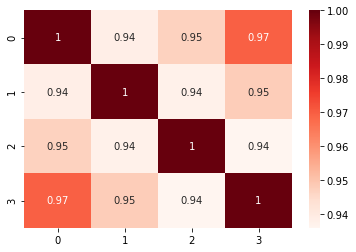

Ensemble-CV: 0.897319+0.0006144574842900049
best nrounds: 52
Ensemble-test 0.89315


[I 2020-03-13 02:16:03,347] Finished trial#0 resulted in value: 0.8931470616003745. Current best value is 0.8931470616003745 with parameters: {'lr_C': 0.08699007805103132, 'xgb_max_depth': 7, 'xgb_subsample': 0.55, 'xgb_scale_pos_weight': 0.8, 'xgb_colsample_bytree': 0.6, 'xgb_colsample_bynode': 0.5, 'xgb_colsample_bylevel': 0.7, 'cb_depth': 7, 'cb_l2_leaf_reg': 11, 'cb_subsample': 0.7}.


rf-CV AUC is 0.88540
lr-CV AUC is 0.88048
cb-CV AUC is 0.89154
xgb-CV AUC is 0.89194


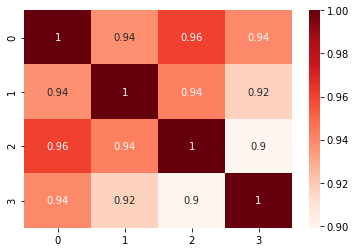

Ensemble-CV: 0.8979650000000001+0.0005974596220666556
best nrounds: 61
Ensemble-test 0.89357


[I 2020-03-13 02:19:06,240] Finished trial#1 resulted in value: 0.89356936188794. Current best value is 0.8931470616003745 with parameters: {'lr_C': 0.08699007805103132, 'xgb_max_depth': 7, 'xgb_subsample': 0.55, 'xgb_scale_pos_weight': 0.8, 'xgb_colsample_bytree': 0.6, 'xgb_colsample_bynode': 0.5, 'xgb_colsample_bylevel': 0.7, 'cb_depth': 7, 'cb_l2_leaf_reg': 11, 'cb_subsample': 0.7}.


rf-CV AUC is 0.88540
lr-CV AUC is 0.87996
cb-CV AUC is 0.89056
xgb-CV AUC is 0.89034


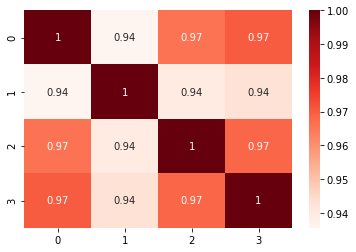

Ensemble-CV: 0.8969490000000001+0.00026924090823402484
best nrounds: 58
Ensemble-test 0.89279


[I 2020-03-13 02:29:02,277] Finished trial#2 resulted in value: 0.8927854903364634. Current best value is 0.8927854903364634 with parameters: {'lr_C': 0.14834030787512134, 'xgb_max_depth': 9, 'xgb_subsample': 0.8500000000000001, 'xgb_scale_pos_weight': 1.0, 'xgb_colsample_bytree': 0.8, 'xgb_colsample_bynode': 0.5, 'xgb_colsample_bylevel': 0.6, 'cb_depth': 12, 'cb_l2_leaf_reg': 19, 'cb_subsample': 0.6}.


{'lr_C': 0.14834030787512134,
 'xgb_max_depth': 9,
 'xgb_subsample': 0.8500000000000001,
 'xgb_scale_pos_weight': 1.0,
 'xgb_colsample_bytree': 0.8,
 'xgb_colsample_bynode': 0.5,
 'xgb_colsample_bylevel': 0.6,
 'cb_depth': 12,
 'cb_l2_leaf_reg': 19,
 'cb_subsample': 0.6}

In [31]:
study = optuna.create_study()
study.optimize(objective, n_trials=3)
study.best_params

In [38]:
study.trials_dataframe().to_csv("optuna_result0.csv")

,number,value,datetime_start,datetime_complete,params_cb_depth,params_cb_l2_leaf_reg,params_cb_subsample,params_lr_C,params_xgb_colsample_bylevel,params_xgb_colsample_bynode,params_xgb_colsample_bytree,params_xgb_max_depth,params_xgb_scale_pos_weight,params_xgb_subsample,system_attrs__number,state
0,0,0.893147,2020-03-13 02:14:19.368127,2020-03-13 02:16:03.347513,7,11,0.7,0.086990,0.7,0.5,0.6,7,0.8,0.55,0,COMPLETE
1,1,0.893569,2020-03-13 02:16:03.350147,2020-03-13 02:19:06.240089,10,8,0.7,0.104069,0.5,0.7,0.8,10,0.2,0.95,1,COMPLETE
2,2,0.892785,2020-03-13 02:19:06.243527,2020-03-13 02:29:02.276629,12,19,0.6,0.148340,0.6,0.5,0.8,9,1.0,0.85,2,COMPLETE
